In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('seaborn-whitegrid')

from utils import PkdbModel, ccolors ,markers,category_filter,filter_df,\
    abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance.groupby("study")

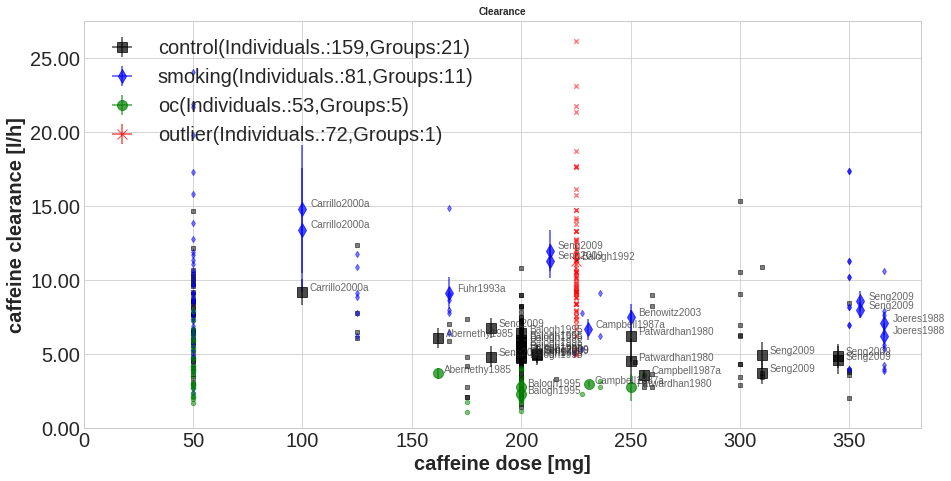

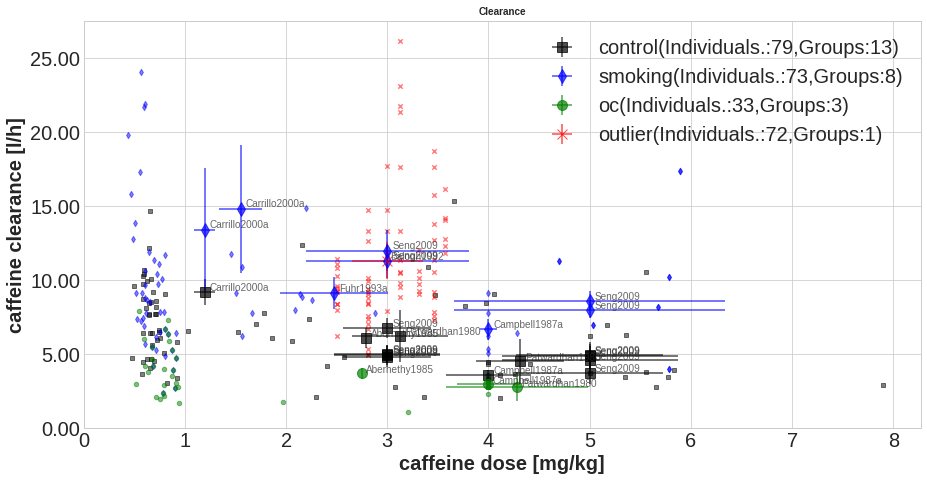

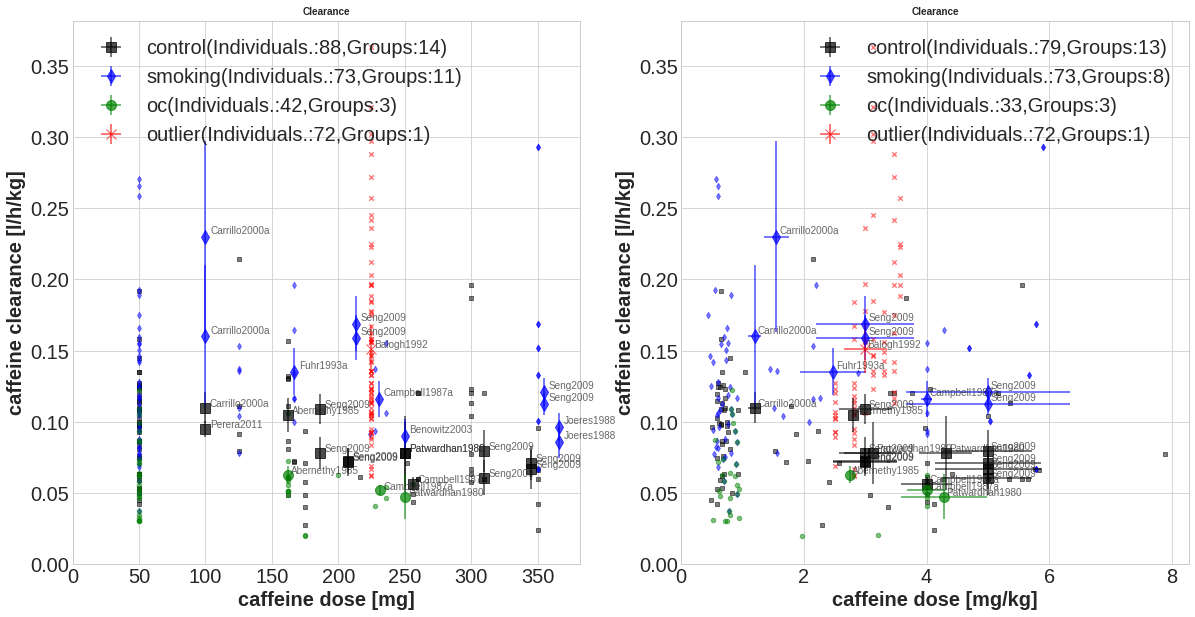

In [4]:
# caffeine clearance
fig05, ax1, = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
fig1, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))

fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
dinds = [abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
         rel_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
         abs_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit"),
         rel_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit")]

for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
    df = caffeine_clearance[inds & individual_idx(caffeine_clearance)]
    df_group = caffeine_clearance[inds & group_idx(caffeine_clearance)]

    for category in ccolors:
        cf_filter = category_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        y = df_category["value"]
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], alpha=0.5,label=None,  s=20)
        units = df_category["unit"].unique()
        unit_intervention = df_category["unit_intervention"].unique()

        assert len(units) <= 1, units
        try:
            ax.set_ylabel(f'caffeine clearance [{units[0]}]')
            ax.set_xlabel(f'caffeine dose [{unit_intervention[0]}]')
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        except IndexError: 
            pass
        
        df_category = filter_df(cf_filter,df_group)
        df_category = df_category[df_category["mean"].notnull()]

        x_group = df_category["value_intervention"]
        y_group = df_category["mean"]
        #count_group = list(df_category[("weight","count")])
        if ax in (ax2, ax4):
            xerr_group = (df_category[("weight","sd")]/df_category[("weight","mean")])*x_group
        else:
            xerr_group = 0
        yerr_group = df_category["se"]

        ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group,color=ccolors[category], fmt=markers[category],  label=f"{category}(Individuals.:{len(x)},Groups:{len(x_group)})",ms=10, alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x_group.iloc[[i]]+(0.01*x_group.max()),
                              y_group.iloc[[i]]+(0.01*y_group.max())), alpha=0.7)
        
for ax in (ax1, ax2, ax3, ax4):

    ax.set_title('Clearance')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend()

fig1.savefig("reports/caf_cl_01.svg", bbox_inches="tight")


In [5]:
caffeine_clearance.groupby("study").get_group("Balogh1995").groupby(('oral contraceptives', 'choice')).count()

,study,output_type,pk,tissue,substance_name,pktype,unit,interventions,individual_pk,value,...,"(percent fat, mean)","(percent fat, sd)","(percent fat, se)","(percent fat, unit)","(metabolic ratio, count)","(metabolic ratio, max)","(metabolic ratio, mean)","(metabolic ratio, min)","(metabolic ratio, unit)",outlier
"(oral contraceptives, choice)",,,,,,,,,,,,,,,,,,,,,
N,88,88,88,88,88,88,88,88,80,80,...,0,0,0,0,0,0,0,0,0,88
Y,22,22,22,22,22,22,22,22,20,20,...,0,0,0,0,0,0,0,0,0,22
